# Chapter 19 Classification Models and Evaluation
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

Dataset: Credit risk https://datahub.io/machine-learning/credit-g

In [143]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

In [144]:
loc = "credit-g.csv"
start_time = time.time()
df = pd.read_csv(loc)
print("It took %s seconds to load the .xlsx file." % (time.time() - start_time))

It took 0.00599980354309082 seconds to load the .xlsx file.


Data Wrangling ... one hot encodings, type conversion

In [145]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")

# one hot encodings
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine Dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function, to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... Make sure type is good. We change the type from str to numeric here, and any 
#df['Installs'] = pd.to_numeric(df['Installs'], errors ='coerce').fillna(0).astype('int')
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,22,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,4,23,1,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1


## Imbalanced datasets

Imbalanced dataset.... 0    700
1    300
Name: class, dtype: int64
0    700
1    300
Name: class, dtype: int64


<AxesSubplot:ylabel='Type'>

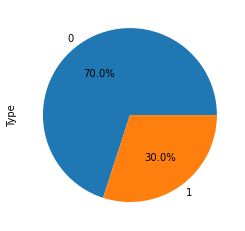

In [146]:
print('Imbalanced dataset....', df['class'].value_counts())
print(df['class'].value_counts())

df.groupby('class').size().plot(kind='pie', y = 'class', label = "Type",  autopct='%1.1f%%')

Upsampling ...creating new data points to balance the classes so as our models are not biased. Simply resample the bad credits (the minority class) to get us a balanced dataset

NOTE: First we need to create our test and train sets, and then we can upsample from our training set. This is to keep the training set in sample and the testing set strictly out of sample (ie our learner does not see any of the test samples until we run the test)

In [147]:
# Prepare our X and y variables and wrap as a function
# Note that train_test_split upsamples to balance our dataset...
def get_train_test_sets(df: pd.DataFrame, test_split: float = 0.2) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    # Define X variables
    cols  = list(df.columns)
    cols.remove('class')

    # Contains only numerics
    X = df[cols]
    y = df['class']
    
    #Test and train    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=None) #42)
    
    return (X_train, y_train, X_test, y_test)
    
#Run the func
X_train, y_train, X_test, y_test = get_train_test_sets(df_upsample)

train_test_split actually upsamples to balance the training data

Imbalanced dataset.... 1    574
0    546
Name: class, dtype: int64
1    574
0    546
Name: class, dtype: int64


<AxesSubplot:ylabel='Type'>

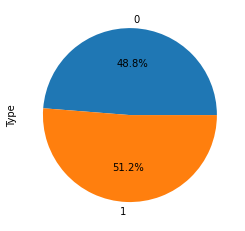

In [150]:
temp = pd.concat([X_train, y_train], axis=1)

print('Imbalanced dataset....', temp['class'].value_counts())
print(temp['class'].value_counts())

temp.groupby('class').size().plot(kind='pie', y = 'class', label = "Type",  autopct='%1.1f%%')

Get the sklearn packages we will need for our clasification problem

In [165]:
import numpy as np
import time 

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix

Now build classification models to identiofy bad credits...

Start fitting models
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
DecisionTreeClassifier() 1.0 0.8285714285714286


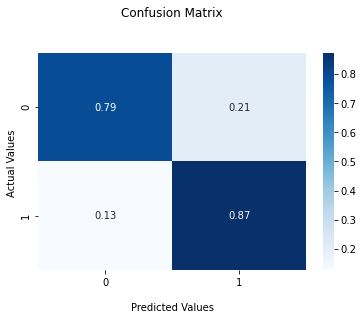

<class 'sklearn.naive_bayes.GaussianNB'>
GaussianNB() 0.74375 0.7107142857142857


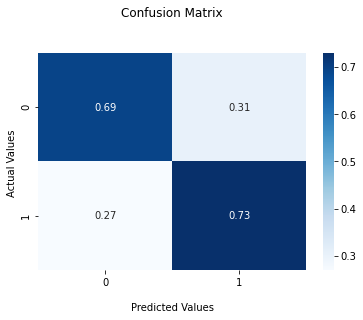

<class 'sklearn.linear_model._logistic.LogisticRegression'>
LogisticRegression(max_iter=2000, random_state=0) 0.7571428571428571 0.7107142857142857


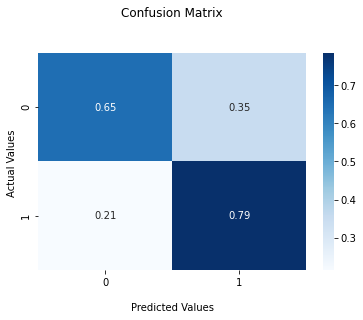

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
RandomForestClassifier(max_depth=5, random_state=0) 0.8214285714285714 0.7607142857142857


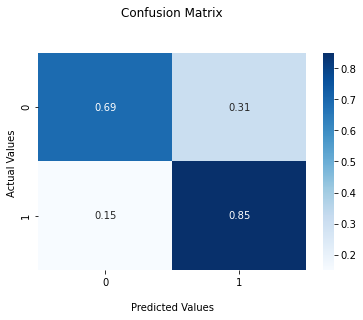

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
MLPClassifier(max_iter=2000, random_state=0) 1.0 0.8571428571428571


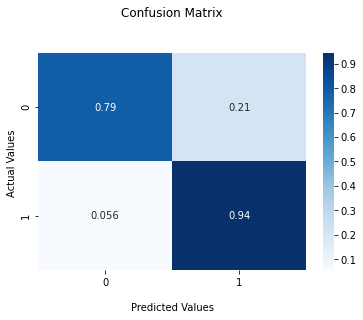

In [160]:

#Func to wrap up running these selected classification learners...
def run_classification_models(X_train: pd.DataFrame, X_test: pd.DataFrame, 
                            y_train: pd.DataFrame, y_test: pd.DataFrame) -> list:
    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    dtc = DecisionTreeClassifier()
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=0)    
    all_models = [dtc, gnb, lr, rf, mlp]
    
    print("Start fitting models")
    for mdl in all_models:
        mdl.fit(X_train,y_train)
        y_train_hat = mdl.predict(X_train)
        y_test_hat = mdl.predict(X_test)

        # Print score
        print(type(mdl))
        print(mdl, mdl.score(X_train,y_train),mdl.score(X_test,y_test))

        #Print confusion matrix...
        cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
        cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues')
        ax.set_title('Confusion Matrix\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        ## Ticket labels - List must be in alphabetical order
        #ax.xaxis.set_ticklabels(['False','True'])
        #ax.yaxis.set_ticklabels(['False','True'])
        ## Display the visualization of the Confusion Matrix.
        plt.show()
    
    return all_models

all_models = run_classification_models(X_train, X_test, y_train, y_test)

## Explainations of Blackbox learners

Let us understand feature importance for our neural net model. We will use permutation_importance to do this

In [166]:
from sklearn.inspection import permutation_importance

In [169]:
X_train.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'foreign_worker', 'checking_status_0<=X<200', 'checking_status_<0',
       'checking_status_>=200', 'checking_status_no checking',
       'purpose_business', 'purpose_domestic appliance', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_new car', 'purpose_other',
       'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining',
       'purpose_used car', 'credit_history_all paid',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'savings_status_100<=X<500',
       'savings_status_500<=X<1000', 'savings_status_<100',
       'savings_status_>=1000', 'savings_status_no known savings',
       'employment_1<=X<4', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7', 'employment_unemployed',
      

In [170]:
# get importance
r = permutation_importance(all_models[3], X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


checking_status_no checking0.071 +/- 0.009
checking_status_<00.020 +/- 0.005
other_payment_plans_bank0.014 +/- 0.003
property_magnitude_real estate0.012 +/- 0.003
credit_history_critical/other existing credit0.011 +/- 0.003
purpose_radio/tv0.011 +/- 0.003
personal_status_female div/dep/mar0.010 +/- 0.004
property_magnitude_car0.007 +/- 0.002
housing_rent0.006 +/- 0.002
purpose_new car0.004 +/- 0.002


In [ ]:
## Auto Machine Learning

In [174]:
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)
predictions = cls.predict(X_test)

ModuleNotFoundError: No module named 'autosklearn'

In [173]:
pip install auto-sklearn


  Using cached auto-sklearn-0.11.1.tar.gz (3.9 MB)
  Using cached auto-sklearn-0.5.2.tar.gz (3.4 MB)
  Using cached typing-3.7.4.3.tar.gz (78 kB)
  Created wheel for auto-sklearn: filename=auto_sklearn-0.3.0-cp38-cp38-win_amd64.whl size=3594605 sha256=d70abdef924656672d27785b454511a1b9e121b570d034cdec66b24f4393a073
  Stored in directory: c:\users\danph\appdata\local\pip\cache\wheels\e7\01\35\c6b8accab3e9aa00257183b9365348313c7ab4b6dd082d04a4
  Created wheel for pynisher: filename=pynisher-0.4.2-py3-none-any.whl size=4218 sha256=f24fd563740744f45704443e9583c076e30e1c354343f4cc94ddaecf3272f577
  Stored in directory: c:\users\danph\appdata\local\pip\cache\wheels\57\17\13\21e9dd80ec0e523b155b7abccd7ce0a9ede7b8073b36d56b2d
  Running setup.py clean for pyrfr
  Created wheel for scikit-learn: filename=scikit_learn-0.19.2-cp38-cp38-win_amd64.whl size=4609242 sha256=a95085fd0d6c1c265a995de3534d57246e30e44304f753d597a212092f5a2b71
  Stored in directory: c:\users\danph\appdata\local\pip\cache\whe

    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\danph\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\danph\\AppData\\Local\\Temp\\pip-install-cusypur1\\auto-sklearn_be2c8a50fb5c4b8193a5f9f95c4fc091\\setup.py'"'"'; __file__='"'"'C:\\Users\\danph\\AppData\\Local\\Temp\\pip-install-cusypur1\\auto-sklearn_be2c8a50fb5c4b8193a5f9f95c4fc091\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\danph\AppData\Local\Temp\pip-pip-egg-info-6o9kfsbc'
         cwd: C:\Users\danph\AppData\Local\Temp\pip-install-cusypur1\auto-sklearn_be2c8a50fb5c4b8193a5f9f95c4fc091\
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\danph\AppData\Local\Temp\pip-install-cusypur1\auto-sklearn_be2c8a50fb5c4b8193a5f9f95c4

  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=938d83842e359dfeb9317011487e3436a4927bf8609b19c9c4b2a6652c61dd02
  Stored in directory: c:\users\danph\appdata\local\pip\cache\wheels\5e\5d\01\3083e091b57809dad979ea543def62d9d878950e3e74f0c930
Successfully built auto-sklearn pynisher scikit-learn smac liac-arff typing
Failed to build pyrfr
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1



      File "C:\Users\danph\AppData\Local\Temp\pip-install-cusypur1\auto-sklearn_4cceee4e36cb458b8a66345cde69dd86\setup.py", line 9, in <module>
        raise ValueError(
    ValueError: Detected unsupported operating system: win32. Please check the compability information of auto-sklearn: https://automl.github.io/auto-sklearn/master/installation.html#windows-osx-compatibility
    ----------------------------------------
    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\danph\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\danph\\AppData\\Local\\Temp\\pip-install-cusypur1\\auto-sklearn_ea744c13907145ddbe451a1b12b06c58\\setup.py'"'"'; __file__='"'"'C:\\Users\\danph\\AppData\\Local\\Temp\\pip-install-cusypur1\\auto-sklearn_ea744c13907145ddbe451a1b12b06c58\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"